<a href="https://colab.research.google.com/github/sergio-qp/AP_2_SQ_AG/blob/master/Proyect_2_Draft%2003_01_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alejandro García and Sergio Quintanilla

In [78]:
import pandas as pd
import numpy as np
# from google.colab import files
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV





## Introduction
This project aims to predict whether employees will leave the company using machine learning techniques.

We explored various models, from baseline methods like Dummy Classifiers to advanced techniques like XGBoost. Key preprocessing steps, including scaling, encoding, and handling class imbalance, were implemented to ensure robust performance. Metrics such as accuracy, balanced accuracy, and F1-score were used to evaluate the models.

By combining predictive power and interpretability, this project provides insights into employee attrition, helping organizations make informed decisions to retain their workforce effectively.

In [79]:

# uploaded=files.upload()
# file_name = list(uploaded.keys())[0]
file_name = "attrition_availabledata_02.csv"
data = pd.read_csv(file_name)

In [80]:
print(data.head())

         hrs  absences  JobInvolvement  PerformanceRating  \
0  10.060048       6.0             3.0                4.0   
1   9.437671       2.0             2.0                3.0   
2   7.900932      20.0             3.0                4.0   
3   7.193853      19.0             4.0                3.0   
4   6.979201       8.0             3.0                3.0   

   EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
0                      2.0              4.0              1.0  31.0   
1                      3.0              4.0              3.0  33.0   
2                      3.0              4.0              3.0  35.0   
3                      4.0              2.0              3.0  28.0   
4                      2.0              4.0              2.0  31.0   

      BusinessTravel              Department  ...  Over18  PercentSalaryHike  \
0  Travel_Frequently  Research & Development  ...       Y               23.0   
1         Non-Travel  Research & Development  ...   

In [81]:

# General Information
num_rows = len(data)  # Number of rows
num_columns = len(data.columns)  # Number of columns

# Column Types
column_types = data.dtypes  # Data types of the columns
column_info = {}
for dtype in column_types.unique():
    column_info[str(dtype)] = sum(column_types == dtype)

# Identify categorical and numerical variables
categorical_vars = [col for col in data.columns if data[col].dtype == 'object']
numerical_vars = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

# Cardinality of categorical variables
categorical_cardinality = {}
for col in categorical_vars:
    categorical_cardinality[col] = data[col].nunique()

# Missing Values
if data.isnull().sum().sum() > 0:
    missing_values = "There are missing values"
else:
    missing_values = "There are no missing values"

# Constant Columns
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
print(f"Constant Columns Removed: {constant_columns}")

# ID Columns
possible_id_columns = []
for col in data.columns:
    if data[col].nunique() == num_rows:
        possible_id_columns.append(col)

# Problem Type (Regression or Classification)
target_variable = data.columns[-1]  # Last column as target
if data[target_variable].nunique() <= 10:
    target_type = 'classification'
else:
    target_type = 'regression'

# Class Distribution (if classification)
if target_type == 'classification':
    class_counts = data[target_variable].value_counts()  # Count each class
    total_counts = len(data[target_variable])  # Total rows
    class_distribution = class_counts / total_counts  # Proportion of each class

    # Check if the dataset is imbalanced
    is_imbalanced = class_distribution.max() > 0.6  # Use .max() with parentheses
else:
    class_distribution = None
    is_imbalanced = None

# EDA Summary
eda_summary = {
    "Number of Rows": num_rows,
    "Number of Columns": num_columns,
    "Column Types": column_info,
    "Categorical Variables": categorical_vars,
    "Numerical Variables": numerical_vars,
    "Categorical Variables Table": pd.DataFrame({
        "Variable": categorical_vars,
        "Cardinality": [categorical_cardinality[col] for col in categorical_vars]
    }),
    "Missing Values": missing_values,
    "Removed Constant Columns": constant_columns,
    "Possible ID Columns": possible_id_columns,
    "Problem Type": target_type,
    "Class Distribution (if classification)": class_distribution,
    "Is Imbalanced": is_imbalanced,
}

for key, value in eda_summary.items():
    print(f"{key}: {value}")




Constant Columns Removed: ['EmployeeCount', 'Over18', 'StandardHours']
Number of Rows: 2940
Number of Columns: 31
Column Types: {'float64': 23, 'object': 8}
Categorical Variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']
Numerical Variables: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical Variables Table:          Variable  Cardinality
0  BusinessTravel            3
1      Department            3
2  EducationField            6
3          Gender            2
4         JobRole            9
5   MaritalStatus            3
6          Over18     

The dataset contains 2940 rows and 31 columns. Of these 31 variables, 23 are numerical variables, and 8 are categorical variables. These categorical variables include: BusinessTravel, Department, or Gender. They have different values; for example, Gender has two unique values: "Female" and "Male." On the other hand, there are other categorical variables, such as JobRole, which have 9 unique values, indicating different roles like Sales Executive or Manager.

Before performing any statistical analysis, it is crucial to check if the dataset contains missing values, as they can cause errors. As observed, the dataset does not have any missing values. Similarly, it is essential to verify if there are variables that have the same value across all observations, as these variables could be removed. In this dataset, Over18, EmployeeCount, and StandardHours are constant variables, which do not provide any useful information and should be eliminated.

To determine whether we have a classification or regression problem, it is necessary to identify our target variable. The target variable is Attrition, whose unique values are "Yes" and "No." Therefore, as it is a categorical variable, this is a classification problem.

The target variable presents significant imbalance, with 83% of the observations corresponding to employees who do not leave ("No") and 16% belonging to the "Yes" category.

## Set Up

In [82]:

# Separate features (X) and target variable (y)
X = data.drop(columns=['Attrition'])  # Drop target variable
y = data['Attrition'].replace({'No': 0, 'Yes': 1})
print(y.value_counts())

# Division de los datos
# Split the dataset into training and testing sets (80/20 split)
seed = 100533387  # Set student id seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)



Attrition
0    2466
1     474
Name: count, dtype: int64


C:\Users\sergi\AppData\Local\Temp\ipykernel_25424\1982002934.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data['Attrition'].replace({'No': 0, 'Yes': 1})


We split our data 80/20 into train and test sets so we can use them for the Holdout method when we want to estimate future performance later.

For inner evaluation, we used 3-fold StratifiedKFold since the target variable is imbalanced. This way, we maintain the proportion of classes in our samples to ensure that one sample does not contain only one class of the target variable.

In [83]:

# Step 1: Identify categorical and numerical columns
# This separates the features into categorical and numerical types for preprocessing.
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()  # List of categorical columns
numerical_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # List of numerical columns

# Step 2: Create a preprocessor
# A ColumnTransformer is used to apply different transformations to categorical and numerical columns.
# - Categorical: OneHotEncoder to convert categories into binary columns.
# - Numerical: 'passthrough' means numerical columns are not transformed.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars),  # Transform categorical variables
        ('num', 'passthrough', numerical_vars)  # Keep numerical variables as is
    ]
)

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, RandomizedSearchCV
inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed) # set up our inner 3fold cv evaluation method



## Basic Methods

In [84]:

# Method 1: Dummy Classifier (Baseline)
# A simple classifier that always predicts the most frequent class. This is used as a baseline for comparison.
start_dummy = time.time()  # Start timing
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=seed)  # Most frequent strategy
dummy_clf.fit(X_train, y_train)  # Train on the training data
dummy_cv_score = -cross_val_score(dummy_clf, X_train, y_train,cv=inner, scoring='neg_root_mean_squared_error').mean() # Get our 3fold CV score
dummy_time = time.time() - start_dummy  # End timing


In [85]:

# Method 2: Decision Tree with Pipeline
# Combines the preprocessor and a Decision Tree model into a single pipeline for clean and efficient workflow.
start_tree = time.time()  # Start timing
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing to the data
    ('classifier', DecisionTreeClassifier(random_state=seed))  # Train a Decision Tree classifier
])
tree_pipeline.fit(X_train, y_train)  # Train the pipeline
tree_cv_score = -cross_val_score(tree_pipeline, X_train, y_train,cv=inner, scoring='neg_root_mean_squared_error').mean() # Get our 3fold CV score
tree_time = time.time() - start_tree  # End timing


In [86]:

# Method 3: KNN with StandardScaler
# Combines preprocessing, scaling (StandardScaler), and KNN model into a single pipeline.
start_knn_std = time.time()  # Start timing
knn_pipeline_std = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('scaler', StandardScaler()),  # Scale features to have mean=0 and std=1
    ('classifier', KNeighborsClassifier())  # Train a KNN classifier
])
knn_pipeline_std.fit(X_train, y_train)  # Train the pipeline
knn_std_cv_score = -cross_val_score(knn_pipeline_std, X_train, y_train,cv=inner, scoring='neg_root_mean_squared_error').mean() # Get our 3fold CV score
knn_std_time = time.time() - start_knn_std  # End timing


In [87]:

# Method 4: KNN with MinMaxScaler
# Similar to the StandardScaler pipeline, but uses MinMaxScaler for scaling.
start_knn_minmax = time.time()  # Start timing
knn_pipeline_minmax = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('scaler', MinMaxScaler()),  # Scale features to range [0, 1]
    ('classifier', KNeighborsClassifier())  # Train a KNN classifier
])
knn_pipeline_minmax.fit(X_train, y_train)  # Train the pipeline
knn_minmax_cv_score = -cross_val_score(knn_pipeline_minmax, X_train, y_train,cv=inner, scoring='neg_root_mean_squared_error').mean() # Get our 3fold CV score
knn_minmax_time = time.time() - start_knn_minmax  # End timing


In [88]:
# Step 5: Display results
# Print the performance metrics (Accuracy and Balanced Accuracy) for all models.
# Additionally, display the time taken for each model.
print("Results:")
print(f"Dummy Classifier - RMSE: {dummy_cv_score:.2f}, Time: {dummy_time:.2f}s")
print(f"Decision Tree - RMSE: {tree_cv_score:.2f}, Time: {tree_time:.2f}s")
print(f"KNN (StandardScaler) - RMSE: {knn_std_cv_score:.2f}, Time: {knn_std_time:.2f}s")
print(f"KNN (MinMaxScaler) - RMSE: {knn_minmax_cv_score:.2f}, Time: {knn_minmax_time:.2f}s")


Results:
Dummy Classifier - RMSE: 0.40, Time: 0.01s
Decision Tree - RMSE: 0.35, Time: 0.20s
KNN (StandardScaler) - RMSE: 0.41, Time: 0.17s
KNN (MinMaxScaler) - RMSE: 0.42, Time: 0.17s


For this section, the following procedures were carried out:

Identification of categorical and numerical columns: As performed in the EDA section, categorical and numerical variables were identified.
Transformation of categorical variables: Categorical variables were converted into binary variables using OneHotEncoder.
Dummy Classifier: This model predicts the most frequent class in the dataset.
Decision Tree and KNN: A Decision Tree model was implemented, as well as KNN, which compares distances between data points. For KNN, the scales of variables can significantly impact the model's performance. Therefore, two types of scaling methods were compared: StandardScaler and MinMaxScaler.

The effectiveness of the various classification methods was calculated and compared. We observed that the dummy classifier was by far the fastest, while all the other models took around the same time as each other to execute. Given that the KNN standard scaler was slightly better than the minmax one and executed slightly faster, we decided to use this one in the following steps of our project.


## HPO to get tuned models

In [89]:
# Decision Trees with Grid-Search

# just a couple of arrays with different parameters to test, IMPORTANT: classifier__ needs to go in front to be used in pipeline
param_grid_tree = {'classifier__max_depth': [10, 20, 30], 'classifier__min_samples_split': [2, 10, 20]} 
start = time.time()  # Start timing

# we use our preexisting tree pipeline
grid_search_tree = GridSearchCV(tree_pipeline,param_grid_tree, cv=inner, scoring='neg_root_mean_squared_error')
grid_search_tree.fit(X_train, y_train)

tg_best_inner = -grid_search_tree.best_score_
tg_best_hp = grid_search_tree.best_params_

tree_grid_time = time.time() - start  # End timing


In [90]:
# Decision Trees with Random-Search

# param distribution this time
param_dist_tree = {'classifier__max_depth':  np.arange(10, 31, 1), 'classifier__min_samples_split': np.arange(2, 21, 1)} 
start = time.time()  # Start timing

# we use our preexisting tree pipeline
random_search_tree = RandomizedSearchCV(tree_pipeline,param_dist_tree, cv=inner, scoring='neg_root_mean_squared_error', n_iter=10, random_state=seed)
random_search_tree.fit(X_train, y_train)

tr_best_inner = -random_search_tree.best_score_
tr_best_hp = random_search_tree.best_params_
tree_random_time = time.time() - start  # End timing


In [91]:
# KNN with Grid-Search

param_grid_knn = {'classifier__n_neighbors': [3,5,7],
                  'classifier__weights': ["uniform","distance"]} 
# we use our preexisting tree pipeline
start = time.time()  # Start timing

grid_search_knn = GridSearchCV(knn_pipeline_std,param_grid_knn, cv=inner, scoring='neg_root_mean_squared_error')
grid_search_knn.fit(X_train, y_train)

kg_best_inner = -grid_search_knn.best_score_
kg_best_hp = grid_search_knn.best_params_
knn_grid_time = time.time() - start  # End timing



In [92]:
# KNN with Random-Search
param_dist_knn = {'classifier__n_neighbors': np.arange(3, 9, 1),
                  'classifier__weights': ["uniform","distance"]} 
start = time.time()  # Start timing

# we use our preexisting tree pipeline
random_search_knn = RandomizedSearchCV(knn_pipeline_std,param_dist_knn, cv=inner, scoring='neg_root_mean_squared_error', n_iter=10, random_state=seed)
random_search_knn.fit(X_train, y_train)

kr_best_inner = -random_search_knn.best_score_
kr_best_hp = random_search_knn.best_params_
knn_random_time = time.time() - start  # End timing



In [113]:

results = {
    "Method": [
        "Dummy Classifier",
        "Decision Tree (Base)",
        "Decision Trees (Grid-Search)",
        "Decision Trees (Random-Search)",
        "KNN (Base)",
        "KNN (Grid-Search)",
        "KNN (Random-Search)"
    ],
    "Inner RMSE": [
        dummy_cv_score,
        tree_cv_score,
        tg_best_inner,
        tr_best_inner,
        knn_std_cv_score,
        kg_best_inner,
        kr_best_inner
    ],
    "Time (s)": [
        dummy_time,
        tree_time,
        tree_grid_time,
        tree_random_time,
        knn_std_time,
        knn_grid_time,
        knn_random_time
    ],
    "Hyperparameters": [
        "NA",
        "Default",
        tg_best_hp,
        tr_best_hp,
        "Default",
        kg_best_hp,
        kr_best_hp
    ]
}

results_df = pd.DataFrame(results)

print("Model Comparison Results:")
print(results_df)




Model Comparison Results:
                           Method  Inner RMSE  Time (s)  \
0                Dummy Classifier    0.401421  0.014030   
1            Decision Tree (Base)    0.353991  0.203005   
2    Decision Trees (Grid-Search)    0.350256  1.398474   
3  Decision Trees (Random-Search)    0.343829  1.383564   
4                      KNN (Base)    0.405610  0.167053   
5               KNN (Grid-Search)    0.330475  0.907001   
6             KNN (Random-Search)    0.330475  1.532112   

                                     Hyperparameters  
0                                                 NA  
1                                            Default  
2  {'classifier__max_depth': 10, 'classifier__min...  
3  {'classifier__min_samples_split': 3, 'classifi...  
4                                            Default  
5  {'classifier__n_neighbors': 3, 'classifier__we...  
6  {'classifier__weights': 'distance', 'classifie...  


### Decision Trees
We observed a slight improvement over the base parameters (`RMSE: 0.353`) using grid search (`RMSE: 0.350`), and a larger increase in performance when using random search (`RMSE: 0.344`). The added flexibility in random search might have helped the model find more ideal parameters than with just grid search.

### KNN
In the case of KNN, both models returned identical parameters (`RMSE: 0.330`) and therefore identical performance, although grid search was slightly faster. Both performed better than the base KNN classifier (`RMSE: 0.406`), which was the worst performing overall.

### Summary
Regarding execution speed, the tuning step greatly slowed the overall performance of all tuned models in comparison to their base versions. Grid search generally performed slightly faster than random search in KNN, which makes sense given that grid search depends on the amount of parameters input to be tested, which was generally around 3 per field, while random depended on the amount of iterations, which we kept at 10. In trees, they performed about as quickly as each other.


## Model Selection
Our overall best performing classifier was the grid search KNN, although this could be due simply to it arriving at the same parameters as the random search model, albeit a little faster. Regardless, we decided to take keep this model and use it to make our subsequent predictions.

In [95]:
# Outer evaluation
test_predictions = grid_search_knn.predict(X_test)
test_acc = accuracy_score(y_test, test_predictions)
test_bal_acc = balanced_accuracy_score(y_test, test_predictions)
print(f"Grid-Search KNN - Accuracy: {test_acc:.2f}, Balanced Accuracy: {test_bal_acc:.2f}")

Grid-Search KNN - Accuracy: 0.95, Balanced Accuracy: 0.90


We expect an accuracy ranging from 0.95 to 0.90 for our competition data.

In [97]:
X_competition = pd.read_csv('attrition_competition_02.csv')
final_model = grid_search_knn.fit(X,y)
competition_predictions = final_model.predict(X_competition)

In [99]:
# Write the DataFrame to a .csv file
# pd.DataFrame(competition_predictions).to_csv("competition_predictions.csv", index=False)
# import joblib
# joblib.dump(final_model, 'final_model_AG_SQ.joblib')


## Additional Models

In [109]:
import xgboost as xgb
from sklearn.base import BaseEstimator, ClassifierMixin

# Using a chatgpt wrapper to fix the compatibility issues

class XGBClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, *args, **kwargs):
        # Initialize the XGBClassifier with passed arguments
        self.model = xgb.XGBClassifier(*args, **kwargs)

    def fit(self, X, y, **kwargs):
        # Fit the model
        return self.model.fit(X, y, **kwargs)

    def predict(self, X):
        # Predict the target labels
        return self.model.predict(X)

    def predict_proba(self, X):
        # Predict probabilities for the classes
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        # Get model parameters
        return self.model.get_params(deep)

    def set_params(self, **params):
        # Set model parameters
        self.model.set_params(**params)

    @property
    def classes_(self):
        # Return the classes learned by the model
        return self.model.classes_

    # Explicitly define the sklearn tags for this model
    @property
    def _sklearn_tags(self):
        # This is the fix for the error you're encountering
        return {
            'estimator_type': 'classifier',
            'requires_y': True,  # XGBClassifier needs labels for classification
            'binary_only': True,  # This is a binary classifier (for binary classification)
            'class_weight': None,
            'multi_class': False
        }


c:\Users\sergi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


XGBoost Optimized with Default Hyperparameters and Categorical Support:
Accuracy: 0.89
Balanced Accuracy: 0.70

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       493
           1       0.85      0.41      0.55        95

    accuracy                           0.89       588
   macro avg       0.87      0.70      0.75       588
weighted avg       0.89      0.89      0.88       588



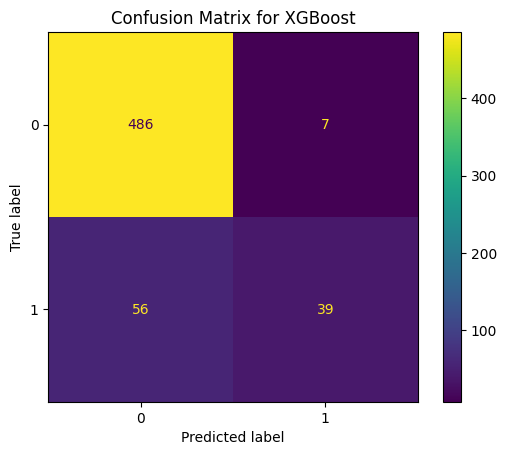

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# This model uses default hyperparameters with support for categorical variables enabled.
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('classifier', XGBClassifierWrapper(n_estimators=100, max_depth=3, eta=0.1, random_state=42, enable_categorical=True))
])

# Fit the model to the training data.
xgb_pipe.fit(X_train, y_train)

# Predict the target variable for the test dataset.
y_pred = xgb_pipe.predict(X_test)

# Calculate accuracy and balanced accuracy to assess model performance.
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Display basic results
print("XGBoost Optimized with Default Hyperparameters and Categorical Support:")
print(f"Accuracy: {accuracy:.2f}")  # Standard accuracy metric
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")  # Balanced metric for imbalanced datasets


# Provides detailed performance metrics (precision, recall, F1-score) for each class.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix visualization for true vs predicted classes.
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_pipe.classes_)
disp.plot(cmap='viridis')  # Use a visually appealing colormap
plt.title("Confusion Matrix for XGBoost")
plt.show()

The decision to implement XGBoosting as an additional model stems from its origins in Gradient Boosting, leveraging ensemble-based trees to enhance processing speed and improve model robustness compared to basic methods. One of the key advantages of XGBoost is its ability to handle categorical variables directly, without requiring preprocessing. However, it is significantly more complex than previously applied models. In this case, we used the default hyperparameters.

The model achieved a balanced accuracy of 70%, but it struggles to predict the minority class. For the minority class (1 - "Employees who leave"), only 41% are correctly identified, with an F1-score of 55%. This reflects moderate performance, as the model has a high number of false negatives.

For Class 0 ("Do not leave"), all cases were correctly predicted. However, for Class 1 ("Leave"), there were 56 false negatives, meaning these employees were predicted as not leaving when they actually did. These results suggest that while XGBoost performs well overall, it requires further optimization or adjustments to improve its ability to capture the minority class. Either way, this model performed worse than our previously selected one, so without improvement, we would not consider it.